# Phishing Site Predictor

Phishing is among the most concerning issues in a constantly changing world. The increasing use of the Internet has led to a new way of stealing data, known as cybercrime. Cybercrime refers to stealing private information and violating privacy through computers. The primary technique used is phishing. Phishing via URLs (Uniform Resource Locators) is one of the most common types, and its primary goal is to steal the data from the user when the user accesses the malicious website. This work aims to provide a solution for detecting such websites with the help of machine learning algorithms focused on the behaviors and qualities of the suggested URL.

### Import Libraries

In [32]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix
import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics
import matplotlib.pyplot as plt # provide object-oriented API for embedding plots into applications
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup
from selenium import webdriver
import networkx as nx

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline

###**O: OBTAIN**


> Obtain data & data cleaning

### Loading Dataset

In [33]:
phish_data = pd.read_csv('phishing_site_urls.csv')

In [34]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [35]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [36]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [37]:
phish_data.isnull().sum()

URL      0
Label    0
dtype: int64

In [38]:
phish_data.describe()

,URL,Label
count,549346,549346
unique,507195,2
top,jhomitevd2abj3fk.tor2web.org/,good
freq,52,392924


About the dataset:
- dataset contains 549346 unique entries
- there are two columns:
    - URL column containing the website urls
    - Label column containing website url categorisation; good (not a phishing site) or bad (is a phishing site)
- there is no missing value in the dataset

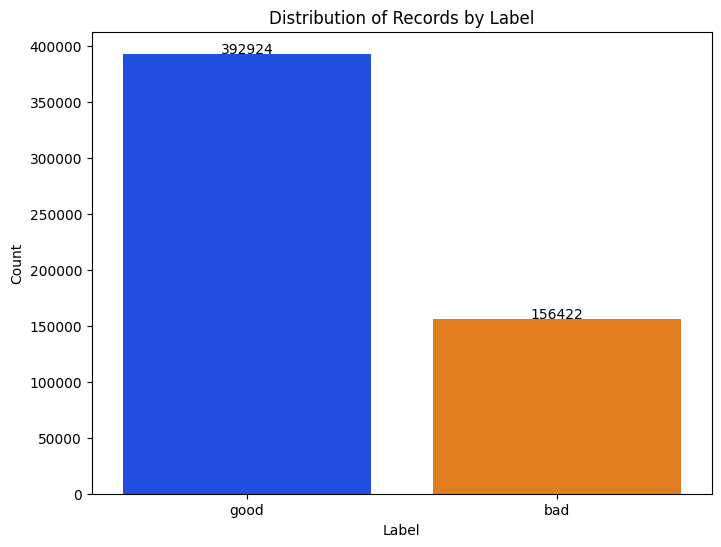

In [39]:
# Count occurence of records for each category in Label column
label_counts = phish_data['Label'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='bright', legend=False)

# Add count values on top of each bar with corresponding color
for i, (index, value) in enumerate(label_counts.items()):
    barplot.text(x=i, y=value + 0.1, s=value, ha='center', color='black')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Records by Label')

# Show the plot
plt.show()

###**S: SCRUB**


> Transforming the raw data to make it suitable for analysis

### Data Preprocessing

RegexpTokenizer
- to extract the alphabet characters, disregarding the non-alphabetic characters from a link in the records in the dataset
- purpose is to extract more features from the data, to classify the web urls as good or bad sites

In [40]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [41]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [42]:
# tokenize the first URL
tokenizer.tokenize(phish_data.URL[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [44]:
# Create a new column named 'text_tokenized' in the phish_data DataFrame
# This column will store the tokens of alphabets extracted from the URLs
phish_data['text_tokenized'] = (
    # Apply a function to each URL in the 'URL' column
    # The function tokenizes each URL using the declared tokenizer object
    phish_data['URL'].map(lambda t: tokenizer.tokenize(t))
)

In [45]:
phish_data.sample(10)

,URL,Label,text_tokenized
112963,odnz73-skazka.com.ua/libraries/bello/index.htm,bad,"[odnz, skazka, com, ua, libraries, bello, inde..."
78656,compilers.iecc.com/comparch/article/98-04-105,good,"[compilers, iecc, com, comparch, article]"
540870,etcolethep.ru/gate.php,bad,"[etcolethep, ru, gate, php]"
210961,maps.thefullwiki.org/English_Montreal_School_B...,good,"[maps, thefullwiki, org, English, Montreal, Sc..."
447596,tigertiger-newcastle.co.uk/groovy/about,good,"[tigertiger, newcastle, co, uk, groovy, about]"
418930,quebecgetaways.com/ohneka-salaberry-de-valleyf...,good,"[quebecgetaways, com, ohneka, salaberry, de, v..."
376805,linkedin.com/pub/dir/rolf/hansen,good,"[linkedin, com, pub, dir, rolf, hansen]"
205930,kul.innosked.com/,good,"[kul, innosked, com]"
505781,dedivan.ru/cart.php?addproduct=269,bad,"[dedivan, ru, cart, php, addproduct]"
43989,www.shop-street.de/wp-content//themes/Snapwire...,bad,"[www, shop, street, de, wp, content, themes, S..."


SnowballStemmer
- is a stemming algorithm used for reducing words to their root or base form
- it is applied after tokenization to further preprocess the text data, normalizing it so that we can better process the text


In [46]:
stemmer = SnowballStemmer("english")

In [47]:
# Create a new column named 'text_stemmed' in the phish_data DataFrame
# Applying stemming to the tokenized words in the 'text_tokenized' column
phish_data['text_stemmed'] = (
    phish_data['text_tokenized'].map(lambda s:
        # Iterate over each word in the tokenized list
        # and apply stemming using the SnowballStemmer object that we declared earlier
        [stemmer.stem(word) for word in s]
    )
)

In [48]:
phish_data.sample(10)

,URL,Label,text_tokenized,text_stemmed
201075,io.stlouisrams.com/mascot/,good,"[io, stlouisrams, com, mascot]","[io, stlouisram, com, mascot]"
326917,facebook.com/david.louie.gong,good,"[facebook, com, david, louie, gong]","[facebook, com, david, louie, gong]"
274029,amazon.com/BYE-Braverman-George-Segal/dp/B002L...,good,"[amazon, com, BYE, Braverman, George, Segal, d...","[amazon, com, bye, braverman, georg, segal, dp..."
250295,turcottehockeyschool.blogspot.com/,good,"[turcottehockeyschool, blogspot, com]","[turcottehockeyschool, blogspot, com]"
527661,cyhttr.tk/hwqdmkekbeketcpe/0bp1tnrmd6fckdbslss...,bad,"[cyhttr, tk, hwqdmkekbeketcpe, bp, tnrmd, fckd...","[cyhttr, tk, hwqdmkekbeketcp, bp, tnrmd, fckdb..."
440213,subpop.com/releases/handsome_furs/full_lengths...,good,"[subpop, com, releases, handsome, furs, full, ...","[subpop, com, releas, handsom, fur, full, leng..."
457132,usidentify.com/l/mayne,good,"[usidentify, com, l, mayne]","[usidentifi, com, l, mayn]"
296998,buy.com/prod/dana-owens-album/63794127.html,good,"[buy, com, prod, dana, owens, album, html]","[buy, com, prod, dana, owen, album, html]"
308327,commercebankreview.com/fisher-investments-lima...,good,"[commercebankreview, com, fisher, investments,...","[commercebankreview, com, fisher, invest, lima..."
174617,en.wikipedia.org/wiki/File:Commission_scolaire...,good,"[en, wikipedia, org, wiki, File, Commission, s...","[en, wikipedia, org, wiki, file, commiss, scol..."


We will combine the stemmed words into single strings by joining them together with spaces. It helps to simplify the representation of text data, and making it more suitable for analysis, visualisation, and modeling purposes.

In [49]:
# Create a new column named 'text_sent' in the DataFrame 'phish_data'
phish_data['text_sent'] = (
    phish_data['text_stemmed'].map(lambda j:
        # Join the stemmed words in each list into a single string separated by spaces
        ' '.join(j)
    )
)

In [50]:
phish_data.sample(10)

,URL,Label,text_tokenized,text_stemmed,text_sent
267065,absoluteastronomy.com/topics/Alexandra_Bridge,good,"[absoluteastronomy, com, topics, Alexandra, Br...","[absoluteastronomi, com, topic, alexandra, bridg]",absoluteastronomi com topic alexandra bridg
71278,thor.info.uaic.ro/~ispdc/,good,"[thor, info, uaic, ro, ispdc]","[thor, info, uaic, ro, ispdc]",thor info uaic ro ispdc
246413,thecypresstimes.com/article/Sports/College/UH_...,good,"[thecypresstimes, com, article, Sports, Colleg...","[thecypresstim, com, articl, sport, colleg, uh...",thecypresstim com articl sport colleg uh men b...
405487,nme.com/artists/cpc-gangbangs,good,"[nme, com, artists, cpc, gangbangs]","[nme, com, artist, cpc, gangbang]",nme com artist cpc gangbang
487854,r0r.me/r/r0r01,bad,"[r, r, me, r, r, r]","[r, r, me, r, r, r]",r r me r r r
528140,ssl.calam-defend.com/,bad,"[ssl, calam, defend, com]","[ssl, calam, defend, com]",ssl calam defend com
218545,music.yahoo.com/sum/,good,"[music, yahoo, com, sum]","[music, yahoo, com, sum]",music yahoo com sum
410603,osisko.com/,good,"[osisko, com]","[osisko, com]",osisko com
281397,anthonyeacom.com/,good,"[anthonyeacom, com]","[anthonyeacom, com]",anthonyeacom com
171689,en.wikipedia.org/wiki/Big_12_Men%27s_Basketbal...,good,"[en, wikipedia, org, wiki, Big, Men, s, Basket...","[en, wikipedia, org, wiki, big, men, s, basket...",en wikipedia org wiki big men s basketbal tour...


### Data Visualisation

In [51]:
# Separate the data frame into bad and good urls
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [52]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [53]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


We will visualise the most common words that appear for bad and good sites respectively

In [54]:
from collections import Counter
def plot_wordcloud(text, title):
    # Generate word frequency counts
    word_freq = Counter(text.split())

    # Exclude default stopwords and additional stopwords
    stopwords = set(STOPWORDS).union({'com', 'http'})
    for stopword in stopwords:
        word_freq.pop(stopword, None)

    # Filter out the most common words (up to 400 words)
    common_words = dict(word_freq.most_common(400))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_words)

    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Convert text data for bad and good sites into single strings
bad_text = ' '.join(bad_sites['text_sent'])
good_text = ' '.join(good_sites['text_sent'])

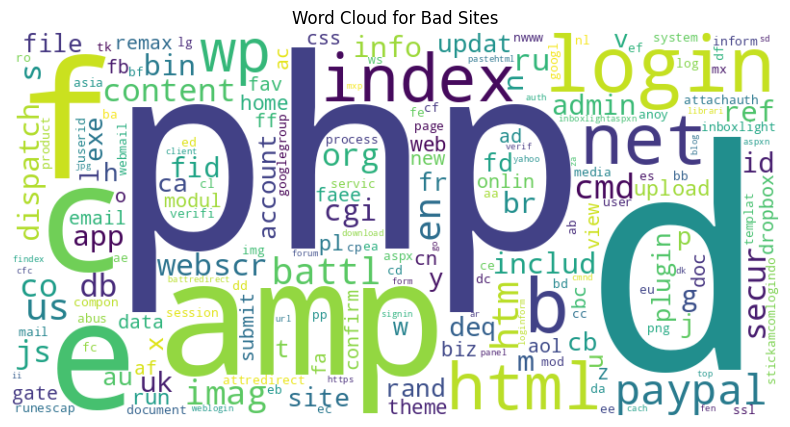

In [56]:
# Plot word cloud for bad sites
plot_wordcloud(bad_text, title='Word Cloud for Bad Sites')

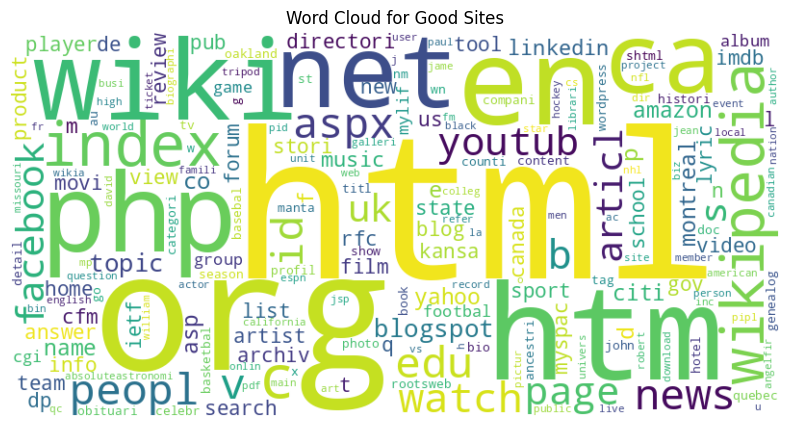

In [57]:
# Plot word cloud for good sites
plot_wordcloud(good_text, title='Word Cloud for Good Sites')

###**E: EXPLORE**
> Exploratory Data Analysis (EDA) to analyse and identify patterns in data

### Data Analysis

In [58]:
# visualize the frequency of top level domains (TLDs) for good vs bad URLs
top_tlds_phish = bad_sites['URL'].apply(lambda x: x.split('.')[-1])
top_tlds_good = good_sites['URL'].apply(lambda x: x.split('.')[-1])

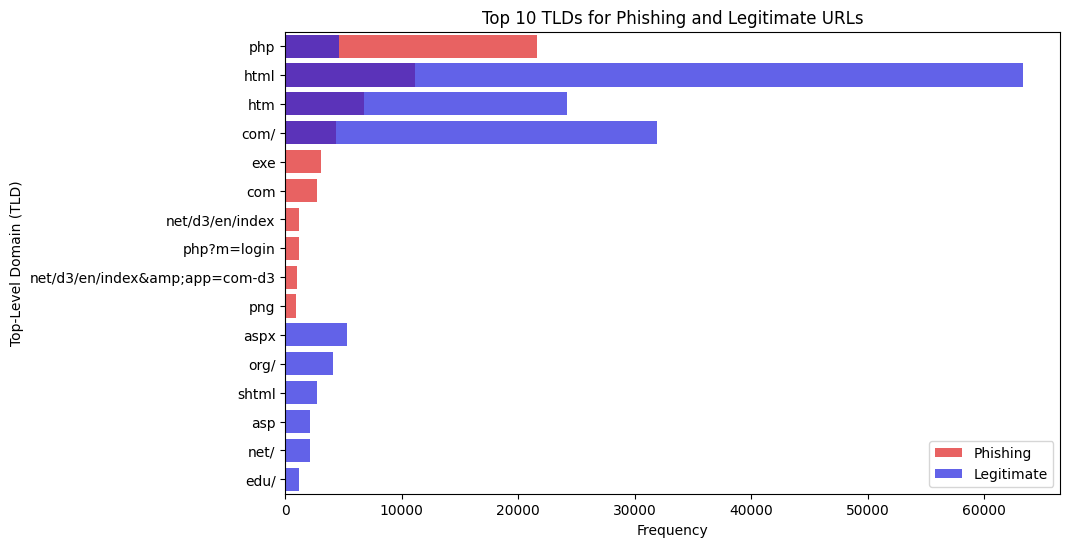

In [61]:
# plot histogram of good vs bad TLDs
plt.figure(figsize=(10, 6))
sns.countplot(y=top_tlds_phish, order=top_tlds_phish.value_counts().index[:10], color='red', alpha=0.7, label='Phishing')
sns.countplot(y=top_tlds_good, order=top_tlds_good.value_counts().index[:10], color='blue', alpha=0.7, label='Legitimate')

plt.title('Top 10 TLDs for Phishing and Legitimate URLs')
plt.xlabel('Frequency')
plt.ylabel('Top-Level Domain (TLD)')
plt.legend()
plt.show()

In [59]:
# statistical Analysis
# calculate the mean URL length for phishing and legit URLs
mean_url_length_phishing = bad_sites['URL'].apply(len).mean()
mean_url_length_legitimate = good_sites['URL'].apply(len).mean()

print("Mean URL length (phishing):", mean_url_length_phishing)
print("Mean URL length (legitimate):", mean_url_length_legitimate)

Mean URL length (phishing): 63.21759726892637
Mean URL length (legitimate): 45.7675122924535


In [77]:
# further statistical explaination
url_length_stats = phish_data.groupby('Label')['URL'].apply(lambda x: x.str.len().describe())
print("URL Length Statistics:")
print(url_length_stats)

URL Length Statistics:
Label       
bad    count    156422.000000
       mean         63.217597
       std          72.013444
       min           1.000000
       25%          26.000000
       50%          40.000000
       75%          72.000000
       max        2307.000000
good   count    392924.000000
       mean         45.767512
       std          24.641329
       min           1.000000
       25%          30.000000
       50%          40.000000
       75%          56.000000
       max        1025.000000
Name: URL, dtype: float64


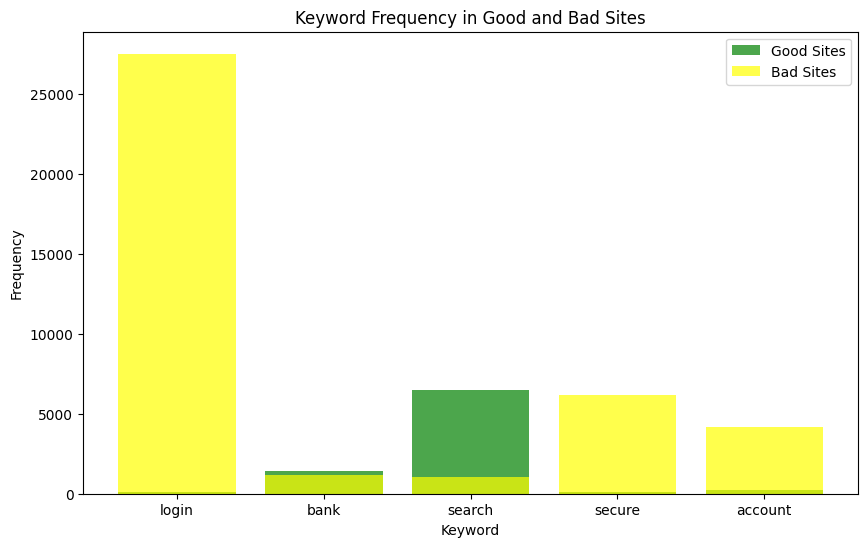

In [86]:
# function to count the frequency of keywords in URLs
def count_keywords(urls, keyword):
    return sum(url.count(keyword) for url in urls)

# keywords of interest (change whenever necessary)
keywords = ['login', 'bank', 'search', 'secure', 'account']

# count keyword frequencies in good and bad sites
keyword_counts_good = {keyword: count_keywords(good_sites['URL'], keyword) for keyword in keywords}
keyword_counts_bad = {keyword: count_keywords(bad_sites['URL'], keyword) for keyword in keywords}

# plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(keyword_counts_good.keys(), keyword_counts_good.values(), color='green', alpha=0.7, label='Good Sites')
plt.bar(keyword_counts_bad.keys(), keyword_counts_bad.values(), color='yellow', alpha=0.7, label='Bad Sites')
plt.title('Keyword Frequency in Good and Bad Sites')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.legend()
plt.show()